<a href="https://colab.research.google.com/github/Maxarreaga/APS360/blob/main/init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the initilization for our APS360 Project

In [1]:
# Imports
from functools import partial
import numpy as np
import pandas as pd 
import random 
import math 
import cv2 
import os 
import shutil
import pathlib
from google.colab import files
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
!mkdir -p root/.kaggle/

In [4]:
!pip install ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

     |████████████████████████████████| 54.7 MB 1.3 MB/s 
     |████████████████████████████████| 119 kB 38.3 MB/s 


In [5]:
def get_kaggle_data():
  print('Upload Kaggle api token :')
  files.upload()
  !pip install -q kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json 

  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data

get_kaggle_data()

Upload Kaggle api token :


Saving kaggle.json to kaggle (1).json
kaggle.json
100% 610M/612M [00:23<00:00, 23.8MB/s]
100% 612M/612M [00:23<00:00, 26.8MB/s]


In [6]:
tran = transforms.Compose([transforms.Resize((32,32)),
                           transforms.Grayscale(),
                           transforms.RandomAffine(degrees=20,translate=(0,0.1),scale=(1,1.2)),
                           #transforms.Normalize((0.5,),(0.5,)),
                           transforms.ToTensor()
                           ])

In [7]:
image_datasets = torchvision.datasets.ImageFolder('/content/Data/Train', transform=tran)

num_images = len(image_datasets)
train_split_val = round(num_images*0.75)


train_set, val_set = torch.utils.data.random_split(image_datasets,[train_split_val,num_images-train_split_val])
print('Train Set: ', len(train_set))
print('Validation Set: ', len(val_set))


Train Set:  29407
Validation Set:  9802


In [14]:
# Pytorch assigns its own numbers as labels so they dont match up with the folder number names in the dataset
# This part is needed to interpret the prediction
dict((int(i),int(l)) for l,i in image_datasets.class_to_idx.items())

{0: 0,
 1: 1,
 2: 10,
 3: 11,
 4: 12,
 5: 13,
 6: 14,
 7: 15,
 8: 16,
 9: 17,
 10: 18,
 11: 19,
 12: 2,
 13: 20,
 14: 21,
 15: 22,
 16: 23,
 17: 24,
 18: 25,
 19: 26,
 20: 27,
 21: 28,
 22: 29,
 23: 3,
 24: 30,
 25: 31,
 26: 32,
 27: 33,
 28: 34,
 29: 35,
 30: 36,
 31: 37,
 32: 38,
 33: 39,
 34: 4,
 35: 40,
 36: 41,
 37: 42,
 38: 5,
 39: 6,
 40: 7,
 41: 8,
 42: 9}

In [8]:
# Creating DataLoader 
batch_size = 100
num_workers = 1
print("trainSet Columns = {}", train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


trainSet Columns = {} <torch.utils.data.dataset.Subset object at 0x7f297ac46490>


In [9]:
def get_accuracy(model, data, device):
    """ Compute the accuracy of the `model` across a dataset `data`
    """

    # From tutorial
    correct,total = 0, 0
    for img, labels in data:
      img, labels = img.to(device), labels.to(device)
      result = model(img)
      pred = result.max(1,keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += labels.shape[0]
    accuracy = correct/total
    return accuracy

In [10]:
# 
class GTSRBClassifier(nn.Module):
  def __init__(self, conv1Channels = 32, conv2Channels = 64, features = 64):
    self.name = "GTSRBClassifier"
    super(GTSRBClassifier,self).__init__()
    self.conv1 = nn.Conv2d(1,conv1Channels,3) #format is in (1 if greyscale 3 if rgb),out channel third number, kernel
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(conv1Channels,conv2Channels,3)
    self.conv3 = nn.Conv2d(conv2Channels,128,3)
    self.fc1 = nn.Linear(2*2*128,features)
    self.fc2 = nn.Linear(features,43)

  def forward(self,image):
    image = self.pool(F.relu(self.conv1(image)))
    image = self.pool(F.relu(self.conv2(image)))
    x = self.pool(F.relu(self.conv3(image)))
    #print("shape x= {}",x.shape)
    x = x.view(x.size(0), -1) #flattening
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1)
    return x

In [11]:
# Curve Plotting
def plotCurve(xData,yData,lineLabel,loss=False):
  plt.plot(xData,yData,label=lineLabel)
  plt.xlabel("Epochs")
  if(loss==True):
    plt.ylabel("Loss")
    plt.title("Epochs vs Loss")
  else:
    plt.ylabel("Accuracy")
    plt.title("Epochs vs Accuracy")


# Training Loop
def train(model, train_loader, valid_loader,batch_size=64, num_epochs=5, learning_rate=1e-4,plot=True):
    
    # allow parallel processing using cuda GPU if available
    dev = "cpu"
    if torch.cuda.is_available():
        print("cuda available, sending data to GPU")
        dev = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

    device = torch.device(dev)  

    model.to(device)

    # set up  
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Creation of arrays for data recording
    trainingLosses = []
    validationLosses = []
    trainingAccuracy = []
    validationAccuracy = []
    iterations = []

    # Training
    for epoch in range(num_epochs):
        # Train Loop
        print("entered training")
        for data,labels  in train_loader:
            #send to cuda GPU if available
            data, labels = data.to(device), labels.to(device)

            #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(data)
            loss = criterion(recon, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        trainingLosses.append(loss)
        trainAccuracy = get_accuracy(model,train_loader,device)
        trainingAccuracy.append(trainAccuracy)
        iterations.append(epoch)

        # get validation data
        print("exited training")
        #Validation loop
        print("entered validation")

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0

        for data,labels in valid_loader:
          #send to cuda GPU if available
          data, labels = data.to(device), labels.to(device)

          #datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
          recon = model(data)
          validationLoss = criterion(recon, labels)
          val_loss = validationLoss.detach().numpy()
          val_steps += 1
        validationLosses.append(validationLoss)
        validAcc = get_accuracy(model,valid_loader,device)
        validationAccuracy.append(validAcc)
        if tune.is_session_enabled():
          tune.report(loss=val_loss, accuracy=validAcc)
        print("Epoch {} ended".format(epoch))
        print("current Training Loss {}, current validation Loss {} ".format(loss,validationLoss))
        print("current Training Accuracy {}, current validation Accuracy {} ".format(trainAccuracy,validAcc))
        PATH = "model_{}batchSize{}LearningRate{}Epoch{}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), PATH)

    #Plotting results
    if(plot == True):
        plotCurve(xData=iterations,yData=trainingLosses,lineLabel="Training",loss=True)
        plotCurve(xData=iterations,yData=validationLosses,lineLabel="Validation",loss=True)
        plt.legend()
        plt.show()
          
        plotCurve(xData=iterations,yData=trainingAccuracy,lineLabel="Training",loss=False)
        plotCurve(xData=iterations,yData=validationAccuracy,lineLabel="Validation",loss=False)
        plt.legend()
        plt.show()

    print("Final training accuracy: {} \n final validation accuracy: {} \n final training loss: {} \n final validation loss: {}".format(trainAccuracy,validAcc,loss,validationLoss))

In [ ]:
# Exports Model for download for real time use
x = torch.randn(1,1,32,32)
torch_out=model(x)
onnx_model_path = "SignDetector.onnx"
torch.onnx.export(model,x,"SignDetector.onnx",export_params=True)

In [12]:
config = {
    "c1": tune.sample_from(lambda _: np.random.randint(40, 150)),
    "c2": tune.sample_from(lambda _: np.random.randint(50, 150)),
    "f1": tune.sample_from(lambda _: np.random.randint(50, 150)),
    "lr": tune.loguniform(5e-4, 5e-2),
    "num_epochs": tune.sample_from(lambda _: np.random.randint(13, 25)),
    "batch_size": tune.choice([128, 256, 350, 512, 800, 1024, 1600, 2048])
}

In [ ]:
def HyperTuning(config, train_loader, valid_loader):
  model = GTSRBClassifier(config["c1"],config["c2"],config["f1"])
  train(model, train_loader, valid_loader, batch_size=config["batch_size"], num_epochs=config["num_epochs"], learning_rate=config["lr"], plot=False)

In [ ]:
smoke_test = False
scheduler = ASHAScheduler(
        metric="loss",
        mode="min")
reporter = CLIReporter(
        metric_columns=["loss", "accuracy"])
result = tune.run(partial(HyperTuning, train_loader=train_loader, valid_loader=val_loader),
                  config=config,
                  scheduler = scheduler,
                  num_samples = 5 if smoke_test else 20,
                  progress_reporter = reporter,
                  resources_per_trial={"cpu": 2, "gpu": 0})
configlist = result.get_all_configs()
btrial = result.get_best_trial("loss", "min", "last")
print(configlist)
print("Best config: ", btrial.config)
print("Best trial loss: ", btrial.last_result["loss"])
print("Best trial accuracy: ", btrial.last_result["accuracy"])

2021-11-27 09:43:33,340	WARNING experiment.py:272 -- No name detected on trainable. Using DEFAULT.
2021-11-27 09:43:33,343	INFO registry.py:70 -- Detected unknown callable for trainable. Converting to class.
2021-11-27 09:43:33,401	WARNING callback.py:115 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2021-11-27 09:43:34 (running for 00:00:00.79)
Memory usage on this node: 1.7/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-11-27_09-43-33
Number of trials: 16/20 (16 PENDING)
+---------------------+----------+-------+--------------+------+------+------+-------------+--------------+
| Trial name          | status   | loc   |   batch_size |   c1 |   c2 |   f1 |          lr |   num_epochs |
|---------------------+----------+-------+--------------+------+------+------+-------------+--------------|
| DEFAULT_7c66d_00000 | PENDING  |       |         2048 |   86 |   72 |   50 | 0.00179846  |           23 |
| DEFAULT_7c66d_00001 | PENDING  |       |         2048 |  135 |  129 |   69 | 0.00124024  |           15 |
| DEFAULT_7c66d_00002 | PENDING  |       |     

entered training
exited training
entered validation
Epoch 0 ended
current Training Loss 1.508152961730957, current validation Loss 0.5157273411750793 
current Training Accuracy 0.5179379059407624, current validation Accuracy 0.5104060395837584 
entered training
exited training
entered validation
Epoch 1 ended
current Training Loss 0.933544933795929, current validation Loss 0.1536286473274231 
current Training Accuracy 0.7949467813785833, current validation Accuracy 0.781371148745154 
entered training
exited training
entered validation
Epoch 2 ended
current Training Loss 0.03202386200428009, current validation Loss 0.5295155644416809 
current Training Accuracy 0.8790424048695888, current validation Accuracy 0.8734952050601918 
entered training
exited training
entered validation
Epoch 3 ended
current Training Loss 0.09608553349971771, current validation Loss 2.281259775161743 
current Training Accuracy 0.9231475499030843, current validation Accuracy 0.9188941032442358 
entered training
e

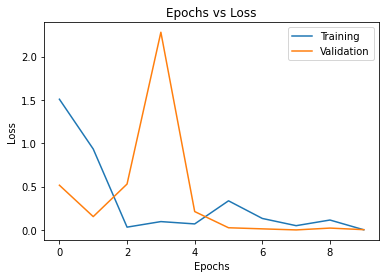

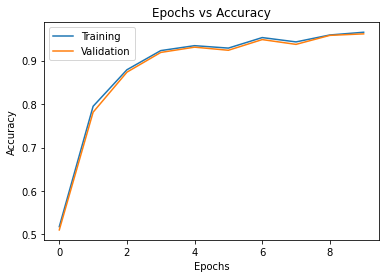

Final training accuracy: 0.9653823919474955 
 final validation accuracy: 0.9616404815343808 
 final training loss: 0.0016427546506747603 
 final validation loss: 0.0029096936341375113


In [ ]:
#running the actual loop
model = GTSRBClassifier()
batch_size = 512
epochs = 10
learningRate = 3e-3
#print(type(train_loader))
train(model=model,train_loader=train_loader,valid_loader=val_loader,batch_size=batch_size,num_epochs=epochs,learning_rate=learningRate,plot=True)